In [1]:
from comet_ml import Experiment
import numpy as np
import argparse
from scipy import signal
from midiutil.MidiFile import MIDIFile
import matplotlib.pyplot as plt
import soundfile
import librosa
import csv
import time
import h5py
import pickle
import os
from sklearn import preprocessing
from scipy.io import wavfile
import pandas as pd
from Repository.utils import constant
from sklearn import metrics as sk_metrics
from joblib import Parallel, delayed
from librosa import display
from librosa.display import specshow
from sklearn.metrics import classification_report, roc_curve, auc
from Repository.models.model import ANN
from Repository.utils.utils import DataProcessor
import wandb
!wandb login a357c1b1a853443058bbe237eaba6a07f8e928a1

Successfully logged in to Weights & Biases!


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\130/.netrc


In [2]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
def recursive_file_search(folder):
    files = [os.path.join(folder, file) for file in os.listdir(folder) if os.path.isfile(os.path.join(folder, file))]
    folders = [os.path.join(folder, file) for file in os.listdir(folder) if os.path.isdir(os.path.join(folder, file))]
    if folders:
        for next_folder in folders:
            files.extend(recursive_file_search(next_folder))

    return files


In [4]:
path = 'MAPS/MAPS1/SptkBGAm/SptkBGAm/ISOL/CH/'

In [5]:
dp = DataProcessor(path)

In [6]:
dp.load_annotations()

In [7]:
dp.load_audios(sr=16000)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    3.1s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    4.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    4.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    9.2s finished


In [8]:
dp.generate_cqts()
X,y = dp.get_cqt_data(from_file=False,cnn=True)
#dp.process_audios(from_file=False)
#X,y = dp.get_cfp_data(from_file=False,cnn=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished


In [9]:
X = X.reshape((X.shape[0], X.shape[3],X.shape[2],X.shape[1]))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))

temp_train = []
temp_test = []
for i in y_train:
    temp_train.append(i)
for i in y_test:
    temp_test.append(i)

y_train = torch.tensor(temp_train)
y_test = torch.tensor(temp_test)

train_dataset = torch.utils.data.TensorDataset(X_train.float(), y_train)
test_dataset = torch.utils.data.TensorDataset(X_test.float(), y_test)

In [11]:
# Data loaders
batch_size = 200
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size, shuffle=False)

In [12]:
# Testing model
def test( class_predictor, device, test_loader):
    class_predictor.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            labels = target
            target =  labels.clone().detach().squeeze().to(device).long()
            output = model(data.float())

            correct += torch.round(torch.sigmoid(output)).eq(target).sum().item()
    return 100. * correct / (len(test_loader.dataset) * 88)

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [14]:
def calculate_avg_accuracy(results, target):
    correct = np.zeros(len(results[0]))
    correct = np.add(correct,torch.eq(results,target).sum(dim=0).detach().cpu().numpy())
    correct /= len(results)
    return correct

In [15]:
def eval(class_predictor,device,test_loader,threshold=0.5):
    class_predictor.eval()
    test_loss = 0
    correct = 0
    all_predicted = []
    predicted_probs = []
    one = torch.ones(1).to(device)
    zero = torch.zeros(1).to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            labels = target
            target = labels.clone().detach().squeeze().to(device).long()
            output = class_predictor(data.float())
            predicted = torch.where(torch.sigmoid(output)>threshold,one,zero).cpu().data.numpy().tolist()
            predicted_probs.extend(torch.sigmoid(output).detach().cpu().numpy().tolist())
            all_predicted.extend(predicted)
    return all_predicted,predicted_probs

In [16]:
def calc_f_score(class_predictor,device,test_loader,y_true,threshold=0.5, average='micro'):
    predictions, probs = eval(class_predictor,device,test_loader,threshold)
    predictions = np.array(predictions)
    y_true = y_true.numpy()
    score = sk_metrics.f1_score(y_true,predictions,average=average)
    acc = sk_metrics.accuracy_score(y_true,predictions)
    pr = sk_metrics.precision_score(y_true,predictions,average=average)
    rec = sk_metrics.recall_score(y_true,predictions,average=average)
    return score,acc, pr, rec

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,(5,3)),
            nn.SELU(),
            nn.Conv2d(32,32,(1,3)),
            nn.SELU(),
            nn.MaxPool2d((2,1)),
            nn.Dropout(0.5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32*40,512),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.Linear(512,512),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.Linear(512,88),
        )
        self.out = nn.Sigmoid()
    def forward(self,x):
        res = self.conv1(x)
        res = res.view(-1,32*40)
        res = self.fc1(res)
        #res = self.out(res)
        return res

In [18]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(550,512),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.Linear(512,512),
            nn.SELU(),
            nn.Dropout(0.5), 
            nn.Linear(512,88),
        )
        self.out = nn.Sigmoid()
    def forward(self,x):
        res = x.view(-1,550)
        res = self.fc1(res)
        
        res = self.out(res)
        return res

In [19]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,0.0,0.05)

In [20]:
model = CNN().to(device)#ANN(257,nn.SELU(),107).to(device)
model.conv1.apply(init_weights)
model.fc1.apply(init_weights)
pos_weight = torch.Tensor([50]*88).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [21]:
from ignite.engine import Engine, _prepare_batch
criterion = nn.BCELoss(reduction='mean')
def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(process_function)

In [22]:
from ignite.engine import Events

log_interval = 200

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(train_loader) + 1
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"
              .format(engine.state.epoch, 
                         iteration, 
                         len(train_loader), 
                         engine.state.output))

In [27]:
wandb.init(project="amt")
cnn_model = CNN().to(device)#ANN(257,nn.SELU(),107).to(device)
cnn_model.conv1.apply(init_weights)
cnn_model.fc1.apply(init_weights)
wandb.watch(cnn_model)
new_optimizer = optim.Adam(cnn_model.parameters(),lr=0.001)
epoch_num = 200
log_interval = 200
losses = []
pos_weight = torch.Tensor([20]*88).to(device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
for epoch in range(epoch_num):
    avg_epoch_loss = 0
    cnn_model.train()
    accuracy = 0
    correct = np.zeros(88)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        labels = target
        target =  labels.clone().detach().squeeze().to(device)
        new_optimizer.zero_grad()
        output = cnn_model(data.float())
        
        loss = loss_function(output.float(), target.float())
        avg_epoch_loss += loss.item()
        loss.backward()
        new_optimizer.step()

        cur_accuracy = calculate_avg_accuracy(torch.round(torch.sigmoid(output)), target)
        correct = np.add(correct,cur_accuracy)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
    
    avg_epoch_loss /= len(train_loader)
    f1_train_micro,sklearn_train_acc, train_prec, train_rec = calc_f_score(cnn_model,device,train_loader,y_train,0.5)
    f1_test_micro,_, _,_ = calc_f_score(cnn_model,device,test_loader,y_test,0.5)
    f1_test_macro, sklearn_acc, test_prec,test_rec = calc_f_score(cnn_model,device,test_loader,y_test,0.5,'macro')
    f1_test_samples, _, _,_ = calc_f_score(cnn_model,device,test_loader,y_test,0.5,'samples')
    wandb.log({"Average batch loss": avg_epoch_loss, "Test F1 Micro Score": f1_test_micro, 
               "Test F1 Macro Score": f1_test_macro, "Test F1 Samples Score": f1_test_samples, 'Train F1 Micro Score' : f1_train_micro,
               "Sklearn_test_accuracy" : sklearn_acc,"Sklearn_train_accuracy" : sklearn_train_acc, 'Train Precsion': train_prec,
               "Train Recall": train_rec, "Test Precision": test_prec, "Test Recall": test_rec})
    correct /= len(train_loader)
    accuracy = np.mean(correct)
    train_accuracy = 100. * accuracy
   
    #test_accuracy = test(model,device,test_loader)
    print('Accuracy is {} on train_dataset'.format(train_accuracy), "\n")

Accuracy is 96.95037105751393 on train_dataset 

Train Epoch: 50 [0/1375 (0%)]	Loss: 0.303600
Accuracy is 96.56679035250463 on train_dataset 

Train Epoch: 51 [0/1375 (0%)]	Loss: 0.280799
Accuracy is 96.50823283858998 on train_dataset 

Train Epoch: 52 [0/1375 (0%)]	Loss: 0.287153
Accuracy is 96.5211038961039 on train_dataset 

Train Epoch: 53 [0/1375 (0%)]	Loss: 0.287761
Accuracy is 96.81238404452691 on train_dataset 

Train Epoch: 54 [0/1375 (0%)]	Loss: 0.285786
Accuracy is 96.54510667903526 on train_dataset 

Train Epoch: 55 [0/1375 (0%)]	Loss: 0.299776
Accuracy is 96.5332792207792 on train_dataset 

Train Epoch: 56 [0/1375 (0%)]	Loss: 0.284822
Accuracy is 96.9383116883117 on train_dataset 

Train Epoch: 57 [0/1375 (0%)]	Loss: 0.278449
Accuracy is 96.97251855287571 on train_dataset 

Train Epoch: 58 [0/1375 (0%)]	Loss: 0.283673
Accuracy is 96.3964517625232 on train_dataset 

Train Epoch: 59 [0/1375 (0%)]	Loss: 0.277166
Accuracy is 96.41175788497218 on train_dataset 

Train Epoch: 60

In [28]:
len(train_loader)

7

In [30]:
import matplotlib.pyplot as plt

In [31]:
predictions,probs = eval(model,device,test_loader,0.01)

In [32]:
np_prediction = np.array(predictions)

In [33]:
probs_class = [x[0] for x in probs]

In [34]:
true_class = [x[0].numpy() for x in y_test]

In [35]:
fpr, tpr, thresholds = roc_curve(true_class, probs_class,)

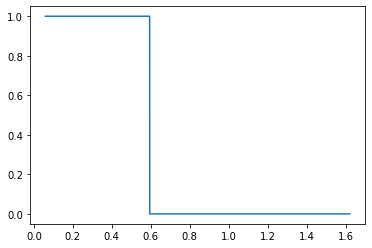

In [36]:
plt.plot(thresholds, tpr)

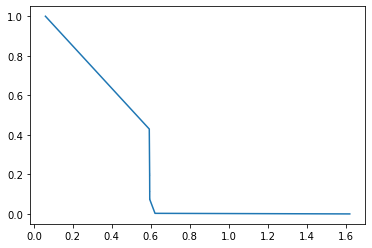

In [37]:
plt.plot(thresholds, fpr)

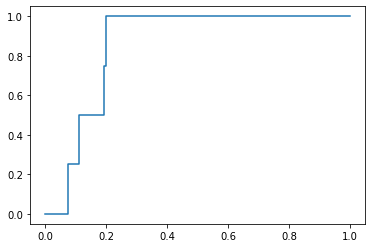

In [38]:
plt.plot(fpr,tpr)

In [40]:
auc_score = auc(fpr,tpr)
auc_score

0.8558823529411764

In [41]:
y_true = y_test.numpy()

In [42]:
y_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [44]:
pred_class = [x[22] for x in predictions]
true_class = [x[22] for x in y_test]

In [45]:
true_positive,false_positive,false_negative, true_negative = [0]*len(predictions[0]),[0]*len(predictions[0]),[0]*len(predictions[0]),[0]*len(predictions[0])